In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout, Reshape, RepeatVector, TimeDistributed, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the dataset
df = pd.read_csv("dataset.csv")
df.index = pd.to_datetime(df["id"], errors="ignore")

# Columns for training
cols = ["humid", "ws100", "wdisp100"]
df_for_training = df[cols].astype(float)

# # Feature Engineering: Create lagged features
# for lag in range(1, 4):  # Lag of 1 to 3 time steps
#     lagged_df = df_for_training.shift(lag).add_suffix(f'_lag_{lag}')
#     df_for_training = pd.concat([df_for_training, lagged_df], axis=1)

# Drop rows with NaN values caused by shifting
df_for_training.dropna(inplace=True)

# Scaling with MinMaxScaler
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

# Define sequence and prediction lengths
sequence_length = 30  # Last 5 hours (30 values)
prediction_length = 6  # Next 1 hour (6 values)

X, y = [], []

# Prepare sequences for input and output
for i in range(len(df_for_training_scaled) - sequence_length - prediction_length + 1):
    X.append(df_for_training_scaled[i: i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length: i + sequence_length + prediction_length, :len(cols)])  # Predicting original cols

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")  # (samples, 36, features)
print(f"Shape of y: {y.shape}")  # (samples, 6, features)

Shape of X: (7526, 30, 3)
Shape of y: (7526, 6, 3)


C:\Users\lucas\AppData\Local\Temp\ipykernel_12080\2996567930.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.index = pd.to_datetime(df["id"], errors="ignore")


In [80]:
# Manual train-test split
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

val_size = int(len(X_train) * 0.1)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]


In [81]:
def custom_loss(y_true, y_pred):
    # Extract the 'ws100' component
    ws100_index = cols.index('ws100')
    y_true_ws100 = y_true[:, :, ws100_index]  # Shape: [batch_size, prediction_length]
    y_pred_ws100 = y_pred[:, :, ws100_index]  # Shape: [batch_size, prediction_length]

    # Compute MSE over other features
    num_features = y_true.shape[-1]
    feature_indices = list(range(num_features))
    feature_indices.remove(ws100_index)  # Exclude 'ws100'

    # Gather other features
    y_true_other = tf.gather(y_true, feature_indices, axis=-1)
    y_pred_other = tf.gather(y_pred, feature_indices, axis=-1)

    # Compute MSE for other features
    mse_other = tf.reduce_mean(tf.square(y_true_other - y_pred_other), axis=-1)  # Shape: [batch_size, prediction_length]

    # Compute MSE for 'ws100'
    mse_ws100 = tf.square(y_true_ws100 - y_pred_ws100)  # Shape: [batch_size, prediction_length]

    # Compute additional weight for 'ws100' near 5 m/s
    threshold = 6.0
    delta = 1.0  # Define a range around the threshold
    condition = tf.abs(y_true_ws100 - threshold) <= delta  # Shape: [batch_size, prediction_length]
    weight_ws100 = tf.where(
        condition,
        tf.constant(2.0),
        tf.constant(1.0)
    )  # Shape: [batch_size, prediction_length]

    # Apply weight to 'ws100' MSE
    weighted_mse_ws100 = mse_ws100 * weight_ws100  # Shape: [batch_size, prediction_length]

    # Combine the losses
    total_loss = mse_other + weighted_mse_ws100  # Shape: [batch_size, prediction_length]

    # Compute the mean loss over batch and time steps
    return tf.reduce_mean(total_loss)





In [82]:
def build_model(hp):
    # Hyperparameters to tune
    units = hp.Int('units', min_value=128, max_value=512, step=128)
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    
    # Encoder
    encoder_inputs = Input(shape=(sequence_length, X.shape[2]))
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        # Add LSTM layer
        encoder_lstm = LSTM(
            units=units,
            return_sequences=True,  # Return sequences for attention mechanism
            return_state=True,
            activation=activation
        )
        # Get outputs and states
        encoder_outputs, state_h, state_c = encoder_lstm(encoder_outputs)
        # Apply dropout
        encoder_outputs = Dropout(dropout_rate)(encoder_outputs)
    # Capture the last encoder states
    encoder_states = [state_h, state_c]

    # Decoder
    # Use the last hidden state as the initial input to the decoder
    decoder_inputs = RepeatVector(prediction_length)(state_h)
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        # Add LSTM layer
        decoder_lstm = LSTM(
            units=units,
            return_sequences=True,
            activation=activation
        )
        # For the first decoder layer, initialize with encoder states
        if i == 0:
            decoder_outputs = decoder_lstm(decoder_outputs, initial_state=encoder_states)
        else:
            decoder_outputs = decoder_lstm(decoder_outputs)
        # Apply dropout
        decoder_outputs = Dropout(dropout_rate)(decoder_outputs)

    # Attention layer
    attention_outputs = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate decoder outputs with attention outputs
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])

    # Final TimeDistributed layer to generate outputs
    outputs = TimeDistributed(Dense(len(cols), activation='linear'))(decoder_concat_input)

    # Define the model
    model = Model(inputs=encoder_inputs, outputs=outputs)

    # Compile the model with optimizer and custom loss function
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=custom_loss
    )

    return model


In [83]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=1,  
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='wind_speed_prediction'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Use a separate validation set if possible
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

model.summary()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |256               |units
0.0001            |0.0001            |learning_rate
0                 |0                 |dropout_rate
2                 |2                 |num_layers
relu              |relu              |activation

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 36s 186ms/step - loss: 0.2561 - val_loss: 0.0344
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - loss: 0.0242 - val_loss: 0.0293
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 154ms/step - loss: 0.0190 - val_loss: 0.0262
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - loss: 0.0166 - val_loss: 0.0226
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - loss: 0.0155 - val_loss: 0.0229
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - loss: 0.0143 - val_loss: 0.0218
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - loss: 0.0134 - val_loss: 0.0185
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/s

KeyboardInterrupt: 

In [21]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
for train_index, val_index in tscv.split(X_train):
    print(f"Fold {fold}")
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    # Build a new model for each fold
    model = build_model(best_hps)

    # Training
    model.fit(
        X_train_cv, y_train_cv,
        validation_data=(X_val_cv, y_val_cv),
        epochs=50,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    fold += 1

Fold 1
Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0317 - val_loss: 0.0062
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 12/50
188/188 ━━━━━━━━━━━━━━

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
'humid': RMSE = 3.2540, NRMSE = 0.0856, Relative Error = 2.94%


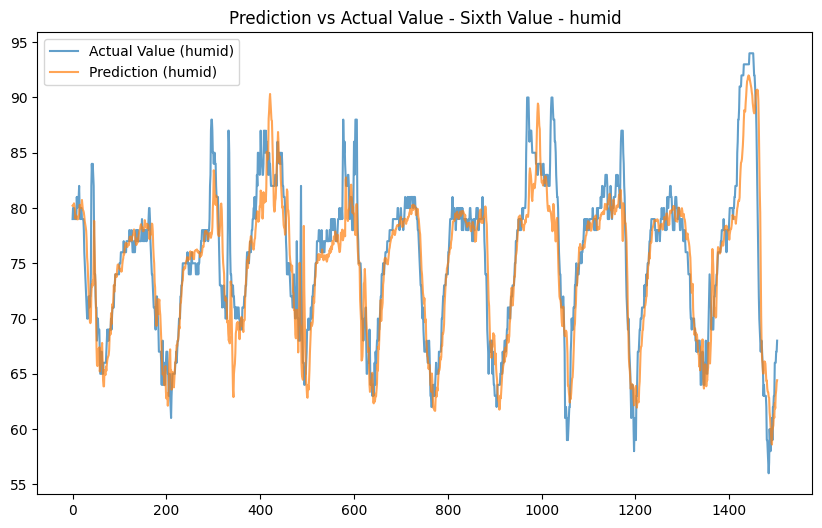

'temp': RMSE = 0.8500, NRMSE = 0.1024, Relative Error = 1.77%


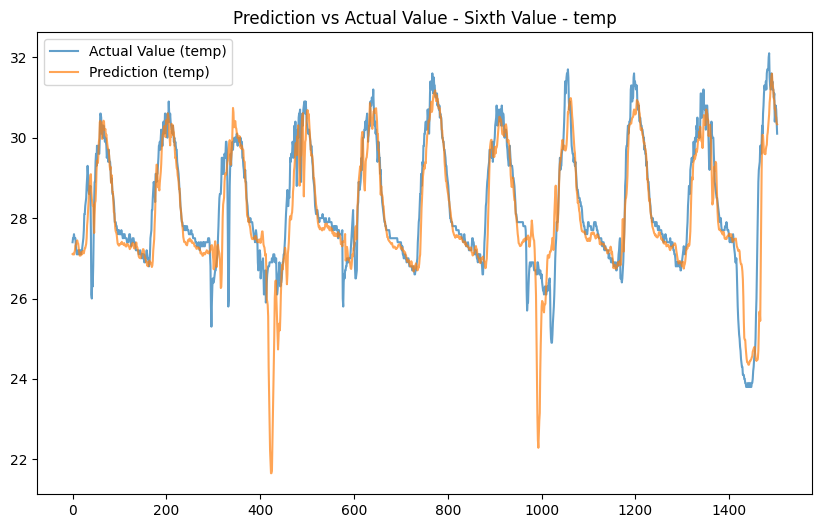

'ws100': RMSE = 1.0734, NRMSE = 0.1103, Relative Error = 11.09%


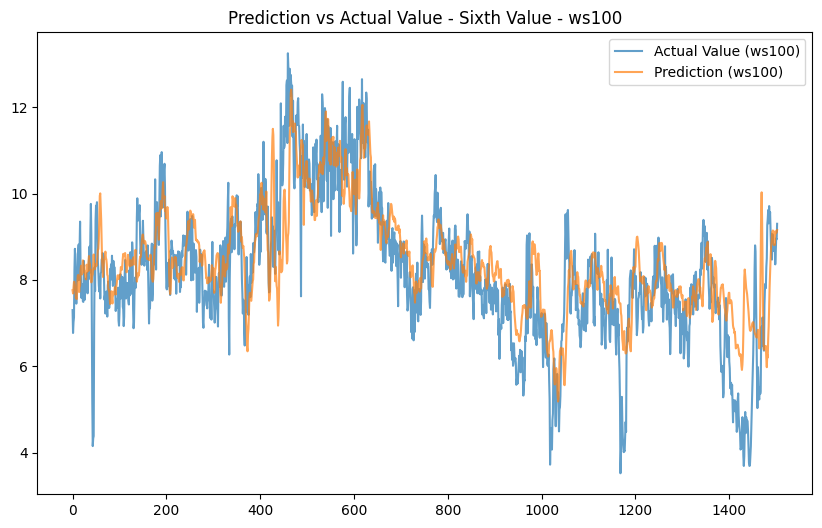

'wdisp100': RMSE = 0.2223, NRMSE = 0.1064, Relative Error = 23.23%


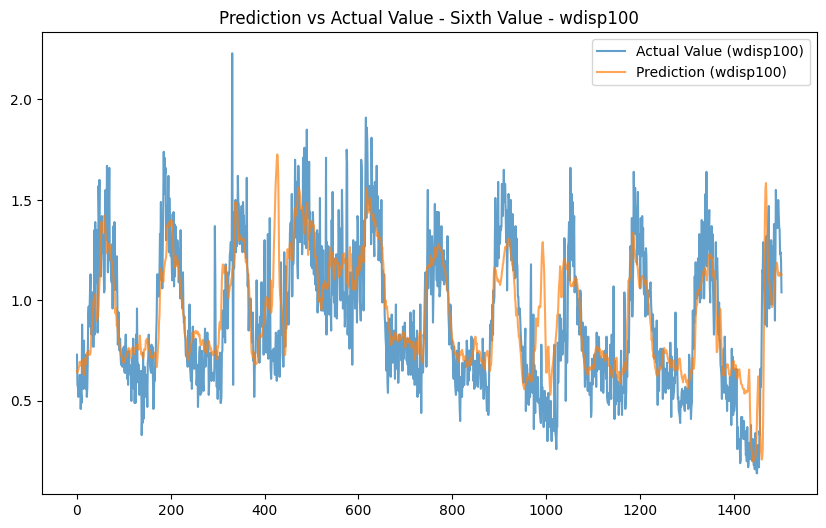

In [22]:
# Final evaluation on the test set
y_pred = model.predict(X_test)

# Inverse transform y_pred
y_pred_flat = y_pred.reshape(-1, len(cols))
y_pred_orig = scaler.inverse_transform(y_pred_flat)
y_pred_orig = y_pred_orig.reshape(-1, prediction_length, len(cols))

# Inverse transform y_test
y_test_flat = y_test.reshape(-1, len(cols))
y_test_orig = scaler.inverse_transform(y_test_flat)
y_test_orig = y_test_orig.reshape(-1, prediction_length, len(cols))


# Evaluate the sixth predicted value
for i, col in enumerate(cols):
    y_true = y_test_orig[:, 5, i]  # Sixth value (index 5)
    y_pred_col = y_pred_orig[:, 5, i]

    rmse = np.sqrt(np.mean((y_true - y_pred_col) ** 2))
    nrmse = rmse / (y_true.max() - y_true.min())
    relative_error = (np.mean(np.abs((y_true - y_pred_col) / y_true)) * 100)

    print(f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Relative Error = {relative_error:.2f}%")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label=f"Actual Value ({col})", alpha=0.7)
    plt.plot(y_pred_col, label=f"Prediction ({col})", alpha=0.7)
    plt.legend()
    plt.title(f"Prediction vs Actual Value - Sixth Value - {col}")
    plt.show()